In [17]:
# Makes report plot
# improt and define basic params
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from pathlib import Path
from os import listdir, path, makedirs
sns.set(style="darkgrid")

# Calibrated data dir
calibrated_base_dir = Path("..")/"../new_calibrate_full/"
calibrated_table_dir = Path("..")/"../tables/"
min_stop_calibrated_base_dir = Path("..")/"../minstop_calibrate_full/"

# Class to use
import sys
sys.path.append("../../python")
from auditing_setup.election_setting import Election

from matplotlib import rc, rc_params
mpl.use('pdf')
plt.rc('font', family='serif', serif='Times')
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
mpl.rcParams["savefig.dpi"] = 200
sns.set(style="darkgrid")
sns.set(font_scale=1.2)
def toggle_tex(to=None):
    if to is not None:
        rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
        rc('text', usetex=to)
    elif mpl.rcParams['text.usetex']:
        rc('text', usetex=False)
    else:
        rc('text', usetex=True)
        
toggle_tex(to=False)
%matplotlib inline

In [212]:
legend_order = ['bravo    | p=0.7 ',
                'bravo    | p=0.55 ',
                'bravo    | p=0.52 ',
                'bravo    | p=0.51 ',
                'bravo_without_replacement | p=0.7 ',
                'bravo_without_replacement | p=0.55 ',
                'bravo_without_replacement | p=0.52 ',
                'bravo_without_replacement | p=0.51 ',
                'bayesian | a=1 | b=1 ',
                'bayesian_with_replacement | a=1 | b=1 ',
                'truncated_bayesian | a=1 | b=1 ',
                'clip     ', 
                'max_sprt ']

def get_position(name):
    for i, legend_pattern in enumerate(legend_order):
        if name.lower().startswith(legend_pattern):
            return i
    else:
        print(name)
        assert False

def reorder_df(df):
    return df.loc[sorted(df.index, key=get_position)]

mpl.rcParams["figure.figsize"] = [8, 6]

def read_csv(file_path, reorder=True):
    df = pd.read_csv(file_path)
    cols = []
    for i in df.columns:
        try:
            cols.append(float(i))
        except Exception as e:
            cols.append(i)
    df.columns = cols
    df.set_index('legend', inplace=True)
    if reorder:
        df = reorder_df(df)
    return df.reset_index()

def get_num_cols(df):
    cols = []
    for i in df.columns:
        try:
            float(i)
            cols.append(float(i))
        except Exception as e:
            pass
    return cols

def format_legend(ax=None, legend=None, how=0):
    if ax is not None:
        legend_ = ax.legend_
    elif legend is not None:
        legend_ = legend
    else:
        return
    
    for text in legend_.texts:
        if how == 0:
            raw = text.get_text()
            text.set_text(raw.replace(" | ", ", ").replace(" ", "").rsplit(",", 1)[0])
        elif how == 1:
            raw = text.get_text()
            print(raw.rsplit(",", 1)[0].replace("_", " "))
            text.set_text(raw.rsplit(",", 1)[0].replace("_", " "))
    return legend_

def make_legend(df, ax, outside=False, *args, **kwargs):
    if outside:
        ax.legend(labels=[basename+" "+parameter for i, (basename, parameter) in 
                          df[['basename_with_type', 'parameter']].drop_duplicates()
                          .iterrows()],
                 bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
                 *args, **kwargs)
    else:
        ax.legend(labels=[basename+" "+(parameter if 'p=' not in parameter else parameter.replace('p=','$p_1$=')) for i, (basename, parameter) in 
                          df[['basename_with_type', 'parameter']].drop_duplicates()
                          .iterrows()], *args, **kwargs)

In [213]:
def pivot_widetable(df, names, groupers, *args, **kwargs):
    df_long = df.melt(*args, **kwargs)
    for name, grouper in zip(names, groupers):
        group = [grouper(i) for i in df_long['variable']]
        df_long[name] = group
    return df_long

names = [
    'type'
    'basename'
    'basename_with_type'
    'parameter'
    'parameter_with_type'
]

basename_map = {'bayesian ': 'Bayesian',
                'max_sprt ': 'MaxBRAVO',
                'bravo    ': 'BRAVO',
                'clip     ': 'ClipAudit',
                'bravo_without_replacement ': 'BRAVO',
                'truncated_bayesian ': 'Bayesian (Least Favourable)',
                'bayesian_with_replacement ': 'Bayesian'}

type_map = {'bayesian ': 'Beta',
            'max_sprt ': '',
            'bravo    ': 'Binomial',
            'clip     ': '',
            'bravo_without_replacement ': 'Hypergeometric',
            'truncated_bayesian ': '',
            'bayesian_with_replacement ': 'Uniform'}

basename_map_with_type = {'bayesian ': 'Bayesian (Beta)',
                          'max_sprt ': 'MaxBRAVO',
                          'bravo    ': 'BRAVO',
                          'clip     ': 'ClipAudit',
                          'bravo_without_replacement ': 'BRAVO (Hypergeometric)',
                          'truncated_bayesian ': 'Bayesian (Least Favourable)',
                          'bayesian_with_replacement ': 'Bayesian (Uniform)'}

def group_basename(name):
    name = name.split('|')[0]
    return basename_map[name]

def group_type(name):
    name = name.split('|')[0]
    return type_map[name]

def group_basename_with_type(name):
    name = name.split('|')[0]
    return basename_map_with_type[name]

def group_parameter(name):
    _, name = name.split('|', 1)
    name = name.rsplit('|', 1)[0] if len(name.rsplit('|', 1)) > 1 else ''
    name = name.replace('|', ',')
    name = name.replace(' ', '')
    return name

def group_parameter_with_type(name):
    _, name = name.split('|', 1)
    type = group_type(_)
    name = name.rsplit('|', 1)[0] if len(name.rsplit('|', 1)) > 1 else ''
    name = name.replace('|', ',')
    name = name.replace(' ', '')
    return type+' '+name
    
groupers = [
    group_type,
    group_basename,
    group_basename_with_type,
    group_parameter,
    group_parameter_with_type
]

filled_markers = (
    'o', 'v', '^', 
    
    '<', '>', '*', 
    
    's', '8', 
    
    'H', 
    
    'D', 
    
    'X')
dash_styles = [
    "",
    (4, 1.5),
    (1, 1),
    
    "",
    (4, 1.5),
    (1, 1),
    
    "",
    (5, 1, 1, 1),
    
    (2, 2, 3, 1.5),
    (1, 2.5, 3, 1.2),
    (5, 1, 2, 1, 2, 1),
]

In [170]:
def prep_long_df(df):
    if 'legend' not in df.columns:
        df = df.reset_index()
    data_long = pivot_widetable(df, [], [], id_vars='legend', var_name='p', value_name='expected_sample')
    types = data_long.legend.apply(group_type)
    basenames = data_long.legend.apply(group_basename)
    parameters = data_long.legend.apply(group_parameter)
    basenames_with_type = data_long.legend.apply(group_basename_with_type)
    parameters_with_type = data_long.legend.apply(group_parameter_with_type)
    data_long['type'] = types
    data_long['basename'] = basenames
    data_long['basename_with_type'] = basenames_with_type
    data_long['parameter'] = parameters
    data_long['parameter_with_type'] = parameters_with_type
    return data_long

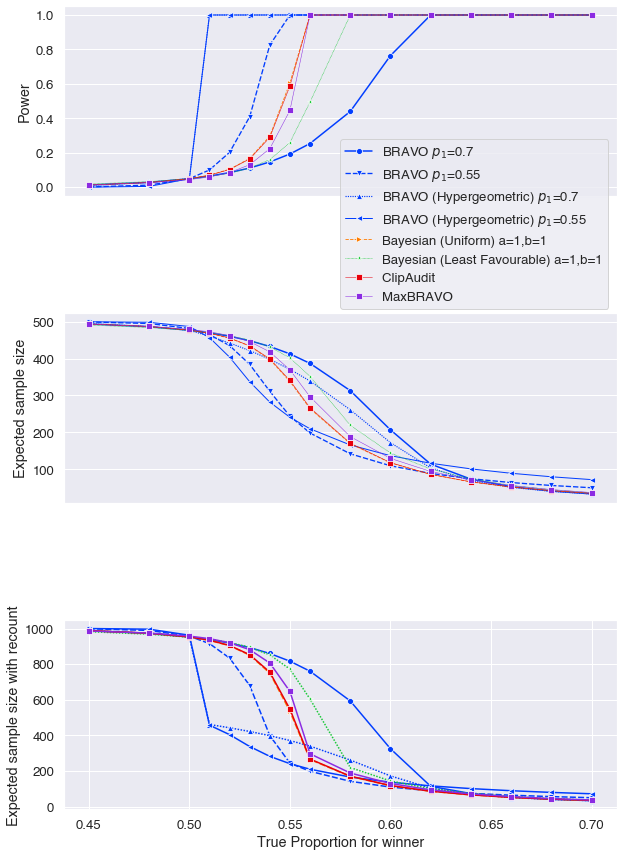

In [218]:
# 1. Basic 20000/2000 plot without replacement

# data
election = Election(500, 500, 0.5, 1, False)
fig = plt.figure(figsize=[9, 12])

data_type = "power.csv"
data_path = calibrated_table_dir/str(election)/data_type
data_long = prep_long_df(read_csv(data_path))
data_long = data_long.query('parameter != "p=0.51" and basename_with_type != "Bayesian (Beta)" and  basename_with_type != "BRAVO (Binomial)"')

ax = fig.add_subplot(311)

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'basename',
    size = 'parameter_with_type',
    style= 'parameter_with_type',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    palette='bright', 
    legend=False, 
    sizes=(0.5, 1.5),
    ax=ax)
ax.xaxis.set_visible(False)
ax.set_ylabel("Power")
make_legend(data_long, ax, bbox_to_anchor=(0.5, 0.3), loc=2, borderaxespad=0.)


data_type = "unconditional_mean.csv"
data_path = calibrated_table_dir/str(election)/data_type
data_long = prep_long_df(read_csv(data_path))
data_long = data_long.query('parameter != "p=0.51" and basename_with_type != "Bayesian (Beta)" and  basename_with_type != "BRAVO (Binomial)"')

ax = fig.add_subplot(312)

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'basename',
    size = 'parameter_with_type',
    style= 'parameter_with_type',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    palette='bright', 
    legend=False, 
    sizes=(0.5, 1.5),
    ax=ax)
ax.set_zorder(-1)

data_type = "unconditional_mean_with_recount.csv"
data_path = calibrated_table_dir/str(election)/data_type
data_long = prep_long_df(read_csv(data_path))
data_long = data_long.query('parameter != "p=0.51" and basename_with_type != "Bayesian (Beta)" and  basename_with_type != "BRAVO (Binomial)"')

ax.xaxis.set_visible(False)
ax.set_ylabel("Expected sample size")

ax = fig.add_subplot(313)

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'basename',
    style= 'parameter_with_type',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    palette='bright', 
    legend=False, 
    ax=ax)
ax.set_zorder(-1)
plt.subplots_adjust(hspace=0.05)

ax.set_xlabel("True Proportion for winner")
ax.set_ylabel("Expected sample size with recount")
fig.tight_layout()
plt.show()

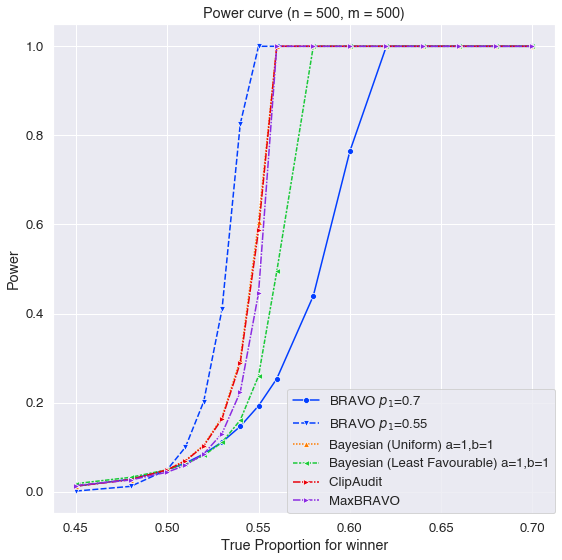

In [219]:
data_type = "power.csv"
data_path = calibrated_table_dir/str(election)/data_type
data_long = prep_long_df(read_csv(data_path))
data_long = data_long.query('parameter != "p=0.51" and basename_with_type != "Bayesian (Beta)" and  basename_with_type != "BRAVO (Hypergeometric)"')

fig = plt.figure(figsize=[9, 9])
ax = fig.add_subplot(111)

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'basename',
    style= 'parameter_with_type',
    data=data_long,
    markers=filled_markers, 
    palette='bright', 
    legend=False, 
    ax=ax)
ax.set_xlabel("True Proportion for winner")
ax.set_ylabel("Power")
ax.set_title('Power curve (n = 500, m = 500)')
make_legend(data_long, ax, 
#             bbox_to_anchor=(0.5, 0.3), 
            loc='lower right', borderaxespad=0.)

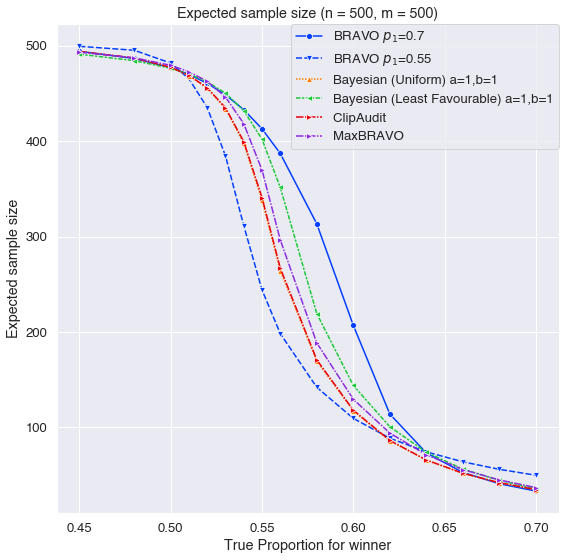

In [220]:
data_type = "unconditional_mean.csv"
data_path = calibrated_table_dir/str(election)/data_type
data_long = prep_long_df(read_csv(data_path))
data_long = data_long.query('parameter != "p=0.51" and basename_with_type != "Bayesian (Beta)" and  basename_with_type != "BRAVO (Hypergeometric)"')

fig = plt.figure(figsize=[9, 9])
ax = fig.add_subplot(111)

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'basename',
    style= 'parameter_with_type',
    data=data_long,
    markers=filled_markers, 
    palette='bright', 
    legend=False, 
    ax=ax)
ax.set_xlabel("True Proportion for winner")
ax.set_ylabel("Expected sample size")
ax.set_title('Expected sample size (n = 500, m = 500)')
make_legend(data_long, ax, 
#             bbox_to_anchor=(0.5, 0.3), 
            loc='upper right', borderaxespad=0.)

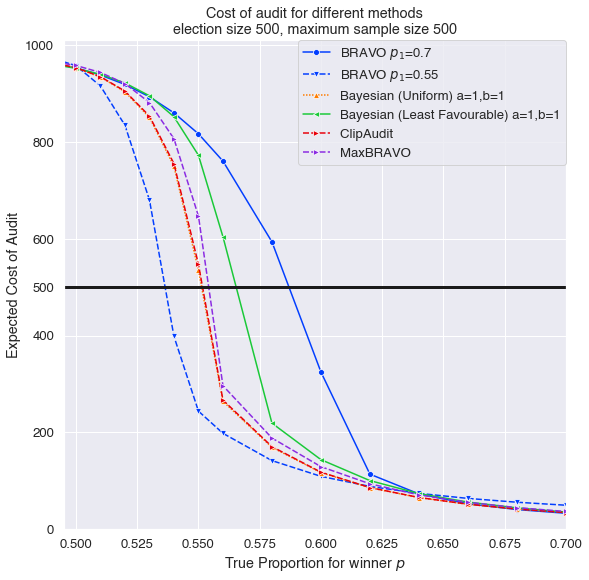

In [221]:
data_type = "unconditional_mean_with_recount.csv"
data_path = calibrated_table_dir/str(election)/data_type
data_long = prep_long_df(read_csv(data_path))
data_long = data_long.query('parameter != "p=0.51" and basename_with_type != "Bayesian (Beta)" and  basename_with_type != "BRAVO (Hypergeometric)"')

fig = plt.figure(figsize=[9, 9])
ax = fig.add_subplot(111)

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'basename',
    style= 'parameter_with_type',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    palette='bright', 
    legend=False, 
    ax=ax)
ax.axhline(500, c='k', linewidth=3)
plt.yticks(list(plt.yticks()[0]) + [500])
ax.set_ylim([0, 1010])
ax.set_xlim([0.495, 0.7])
ax.set_title('Cost of audit for different methods\nelection size 500, maximum sample size 500')
ax.set_xlabel("True Proportion for winner $p$")
ax.set_ylabel("Expected Cost of Audit")
make_legend(data_long, ax, 
#             bbox_to_anchor=(0.5, 0.3), 
            loc='upper right', borderaxespad=0.)

#### Larger

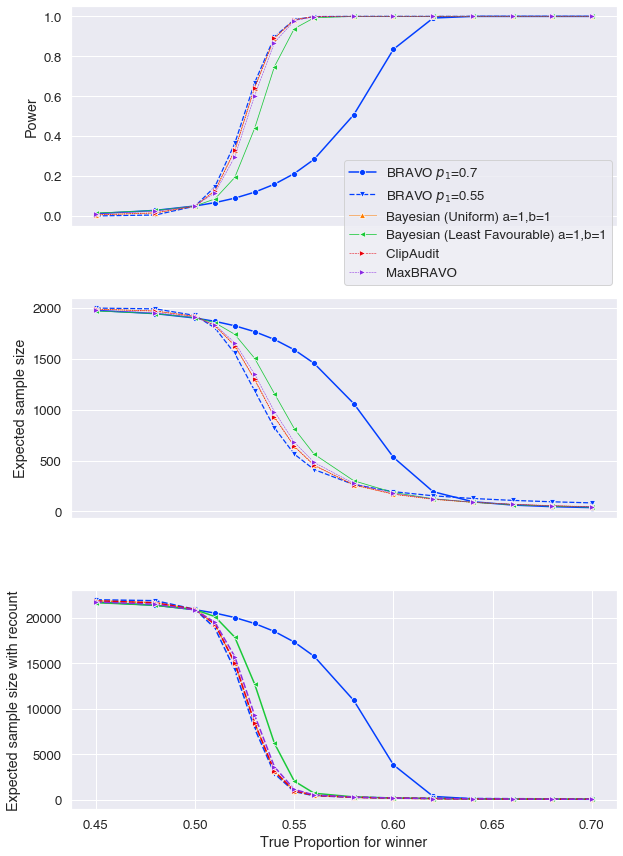

In [222]:
# 1. Basic 20000/2000 plot without replacement

# data
election = Election(20000, 2000, 0.5, 1, False)
fig = plt.figure(figsize=[9, 12])

data_type = "power.csv"
data_path = calibrated_table_dir/str(election)/data_type
data_long = prep_long_df(read_csv(data_path))
data_long = data_long.query('parameter != "p=0.51" and basename_with_type != "Bayesian (Beta)" and  basename_with_type != "BRAVO (Hypergeometric)"')

ax = fig.add_subplot(311)

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'basename',
    size = 'parameter_with_type',
    style= 'parameter_with_type',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    palette='bright', 
    legend=False, 
    sizes=(0.5, 1.5),
    ax=ax)
ax.xaxis.set_visible(False)
ax.set_ylabel("Power")
make_legend(data_long, ax, bbox_to_anchor=(0.5, 0.3), loc=2, borderaxespad=0.)


data_type = "unconditional_mean.csv"
data_path = calibrated_table_dir/str(election)/data_type
data_long = prep_long_df(read_csv(data_path))
data_long = data_long.query('parameter != "p=0.51" and basename_with_type != "Bayesian (Beta)" and  basename_with_type != "BRAVO (Hypergeometric)"')

ax = fig.add_subplot(312)

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'basename',
    size = 'parameter_with_type',
    style= 'parameter_with_type',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    palette='bright', 
    legend=False, 
    sizes=(0.5, 1.5),
    ax=ax)
ax.set_zorder(-1)

data_type = "unconditional_mean_with_recount.csv"
data_path = calibrated_table_dir/str(election)/data_type
data_long = prep_long_df(read_csv(data_path))
data_long = data_long.query('parameter != "p=0.51" and basename_with_type != "Bayesian (Beta)" and  basename_with_type != "BRAVO (Hypergeometric)"')

ax.xaxis.set_visible(False)
ax.set_ylabel("Expected sample size")

ax = fig.add_subplot(313)

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'basename',
    style= 'parameter_with_type',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    palette='bright', 
    legend=False, 
    ax=ax)
ax.set_zorder(-1)
plt.subplots_adjust(hspace=0.05)

ax.set_xlabel("True Proportion for winner")
ax.set_ylabel("Expected sample size with recount")
fig.tight_layout()
plt.show()

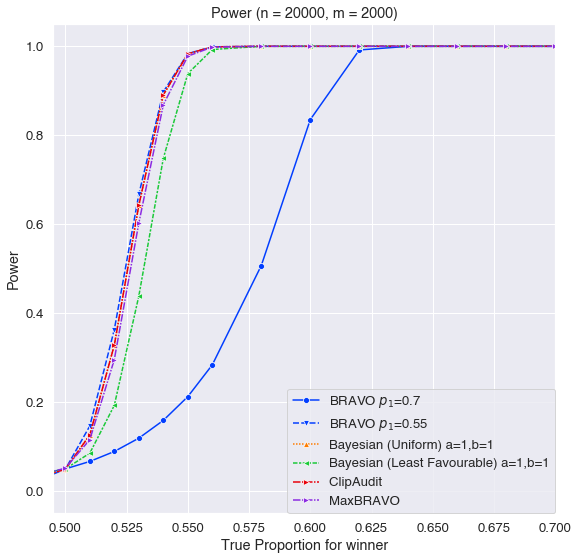

In [223]:
data_type = "power.csv"
data_path = calibrated_table_dir/str(election)/data_type
data_long = prep_long_df(read_csv(data_path))
data_long = data_long.query('parameter != "p=0.51" and basename_with_type != "Bayesian (Beta)" and  basename_with_type != "BRAVO (Hypergeometric)"')

fig = plt.figure(figsize=[9, 9])
ax = fig.add_subplot(111)

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'basename',
    style= 'parameter_with_type',
    data=data_long,
    markers=filled_markers, 
    palette='bright', 
    legend=False, 
    ax=ax)
ax.set_xlim([0.495, 0.7])
ax.set_xlabel("True Proportion for winner")
ax.set_ylabel("Power")
ax.set_title('Power (n = 20000, m = 2000)')
make_legend(data_long, ax, 
#             bbox_to_anchor=(0.5, 0.3), 
            loc='lower right', borderaxespad=0.)

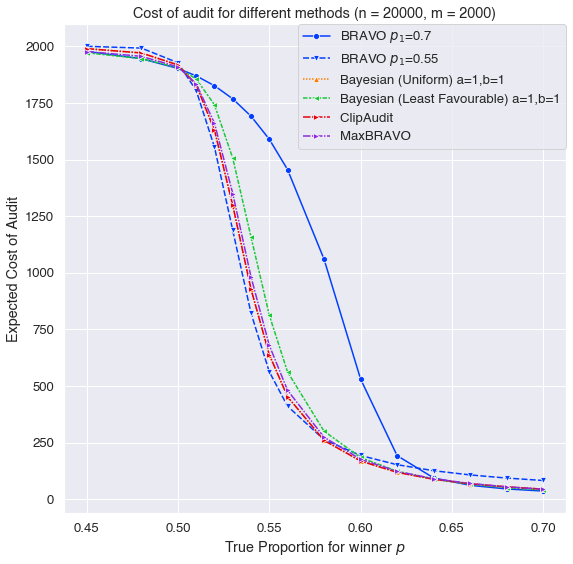

In [224]:
data_type = "unconditional_mean.csv"
data_path = calibrated_table_dir/str(election)/data_type
data_long = prep_long_df(read_csv(data_path))
data_long = data_long.query('parameter != "p=0.51" and basename_with_type != "Bayesian (Beta)" and  basename_with_type != "BRAVO (Hypergeometric)"')

fig = plt.figure(figsize=[9, 9])
ax = fig.add_subplot(111)

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'basename',
    style= 'parameter_with_type',
    data=data_long,
    markers=filled_markers, 
    palette='bright', 
    legend=False, 
    ax=ax)
ax.set_title('Cost of audit for different methods (n = 20000, m = 2000)')
ax.set_xlabel("True Proportion for winner $p$")
ax.set_ylabel("Expected Cost of Audit")

make_legend(data_long, ax, 
#             bbox_to_anchor=(0.5, 0.3), 
            loc='upper right', borderaxespad=0.)

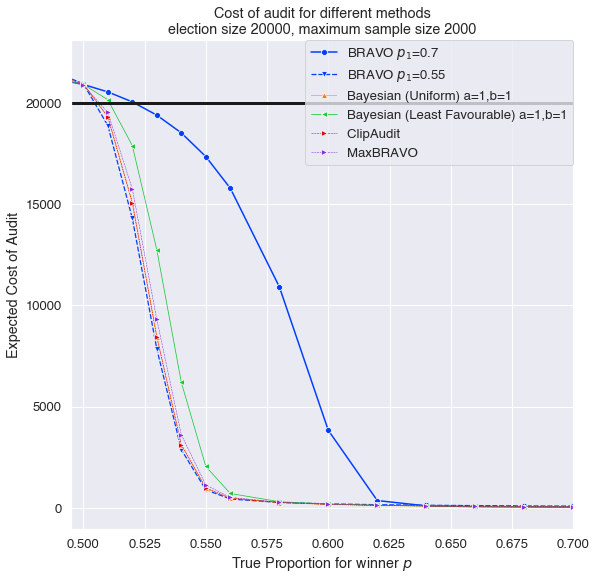

In [225]:
data_type = "unconditional_mean_with_recount.csv"
data_path = calibrated_table_dir/str(election)/data_type
data_long = prep_long_df(read_csv(data_path))
data_long = data_long.query('parameter != "p=0.51" and basename_with_type != "Bayesian (Beta)" and  basename_with_type != "BRAVO (Hypergeometric)"')

fig = plt.figure(figsize=[9, 9])
ax = fig.add_subplot(111)

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'basename',
    size = 'parameter_with_type',
    style= 'parameter_with_type',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    palette='bright', 
    legend=False, 
    sizes=(0.5, 1.5),
    ax=ax)
ax.axhline(20000, c='k', linewidth=3)
ax.set_xlim([0.495, 0.7])
ax.set_title('Cost of audit for different methods\nelection size 20000, maximum sample size 2000')
ax.set_xlabel("True Proportion for winner $p$")
ax.set_ylabel("Expected Cost of Audit")
make_legend(data_long, ax, 
#             bbox_to_anchor=(0.5, 0.3), 
            loc='upper right', borderaxespad=0.)

## 30000

Text(0, 0.5, 'Expected sample size with recount')

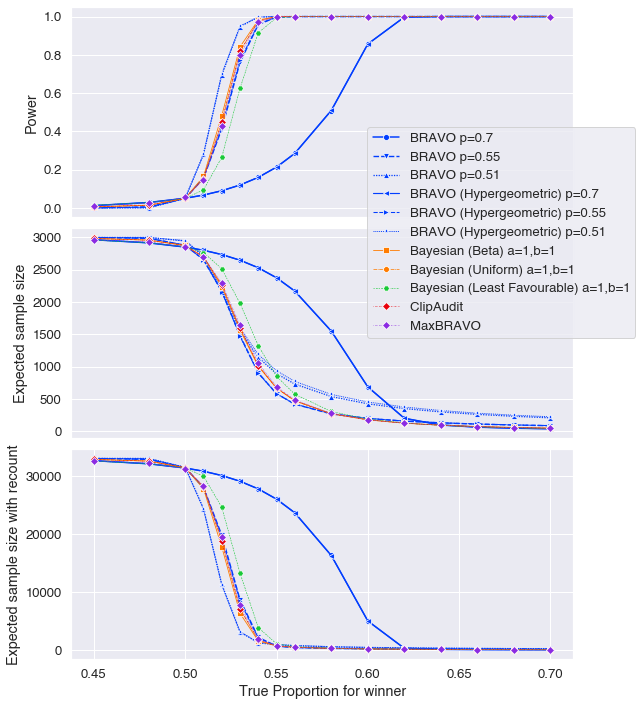

In [179]:
# 1. Basic 30000/3000 plot without replacement

# data
election = Election(30000, 3000, 0.5, 1, False)
fig = plt.figure(figsize=[9, 12])

data_type = "power.csv"
data_path = calibrated_table_dir/str(election)/data_type
data_long = prep_long_df(read_csv(data_path))

ax = fig.add_subplot(311)

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'basename',
    size = 'parameter_with_type',
    style= 'parameter_with_type',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    palette='bright', 
    legend=False, 
    sizes=(0.5, 1.5),
    ax=ax)
ax.xaxis.set_visible(False)
ax.set_ylabel("Power")
make_legend(data_long, ax, bbox_to_anchor=(0.59, 0.43), loc=2, borderaxespad=0.)


data_type = "unconditional_mean.csv"
data_path = calibrated_table_dir/str(election)/data_type
data_long = prep_long_df(read_csv(data_path))

ax = fig.add_subplot(312)

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'basename',
    size = 'parameter_with_type',
    style= 'parameter_with_type',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    palette='bright', 
    legend=False, 
    sizes=(0.5, 1.5),
    ax=ax)
ax.set_zorder(-1)

data_type = "unconditional_mean_with_recount.csv"
data_path = calibrated_table_dir/str(election)/data_type
data_long = prep_long_df(read_csv(data_path))

ax.xaxis.set_visible(False)
ax.set_ylabel("Expected sample size")

ax = fig.add_subplot(313)

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'basename',
    size = 'parameter_with_type',
    style= 'parameter_with_type',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    palette='bright', 
    legend=False, 
    sizes=(0.5, 1.5),
    ax=ax)
ax.set_zorder(-1)
plt.subplots_adjust(hspace=0.05)

ax.set_xlabel("True Proportion for winner")
ax.set_ylabel("Expected sample size with recount")